# **Exam 1st July - Emotion Detection**

**Author**: Morselli Enrico, 979685

enrico.morselli@studio.unibo.it

First thing first, we import all the needed libraries

In [73]:
# data pre-processing
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MultiLabelBinarizer

from collections import OrderedDict

# useful during debugging (progress bars)
from tqdm import tqdm

# typing
from typing import List, Callable, Dict

from tensorflow import keras
from tensorflow.keras import layers

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import classification_report

from functools import partial

## **Data Preprocessing**

### **Loading Data**

Load the .csv files for training, test and validation set by a simple file uploader


In [74]:
# load files using file uploader
from google.colab import files
uploaded = files.upload()

### **Data Exploration**

Let's look a bit into our data

In [75]:
train_set = pd.read_csv('train_ekmann.csv')
test_set = pd.read_csv('test_ekmann.csv')
val_set = pd.read_csv('val_ekmann.csv')

train_set.head(10)

,Text,Emotion,Id
0,My favourite food is anything I didn't have to...,neutral,eebbqej
1,"Now if he does off himself, everyone will thin...",neutral,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,anger,eezlygj
3,To make her feel threatened,fear,ed7ypvh
4,Dirty Southern Wankers,anger,ed0bdzj
5,OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...,surprise,edvnz26
6,Yes I heard abt the f bombs! That has to be wh...,joy,ee3b6wu
7,We need more boards and to create a bit more s...,joy,ef4qmod
8,Damn youtube and outrage drama is super lucrat...,joy,ed8wbdn
9,It might be linked to the trust factor of your...,neutral,eczgv1o


So, our data are composed by some Text labelled with an Emotion and an alphanumeric Id. Let's see how much data we have for each emotion in our training set

In [76]:
train_set['Emotion'].value_counts()

joy         16217
neutral     13146
surprise     5367
anger        4293
sadness      3058
disgust       768
fear          561
Name: Emotion, dtype: int64

Let's try to make a plot

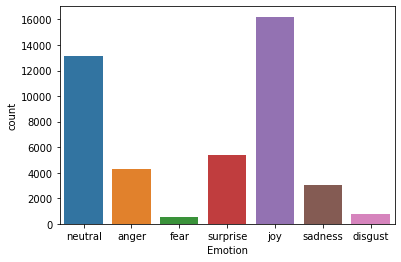

In [77]:
import seaborn as sns
emotions = train_set['Emotion']
sns.countplot(x=emotions, data=train_set);

As we can see from the value counts and the plot, the quantity of data for each emotion is not really balanced. In particular, we have a predominance of "neutral" and "joy".

Let's plot the text length distribution for the training set

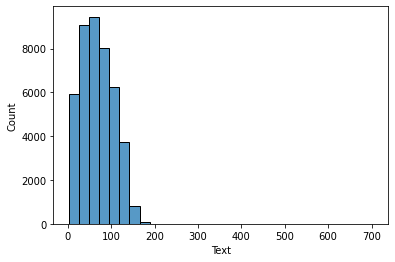

In [78]:
sns.histplot(train_set['Text'].apply(lambda text: len(text)), bins=30);

So we have not really long sequencies

### **Text Preprocessing**

Now its time to make a little bit of pre-processing. I'm not doing too much pre-processing, i just lower the text, remove special characters and uncommon symbols and remove stopwords, but maintaining the negations (not, no, nor) to preserve the intention.

In [79]:
# Config

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

try:
    stopwords = stopwords.words('english')
    stopwords.remove('not')
    stopwords.remove('nor')
    stopwords.remove('no')
    STOPWORDS = set(stopwords)
except LookupError:
    nltk.download('stopwords')
    stopwords = stopwords.words('english')
    stopwords.remove('not')
    stopwords.remove('nor')
    stopwords.remove('no')
    STOPWORDS = set(stopwords)

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)

def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])



PREPROCESSING_PIPELINE = [
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          ]

# Anchor method

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """

    filter_methods = filter_methods if filter_methods is not None else PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)

In [80]:
# Pre-processing

print('Pre-processing text...')

# Replace each sentence with its pre-processed version
train_set['Text'] = train_set['Text'].apply(lambda txt: text_prepare(txt))
test_set['Text'] = test_set['Text'].apply(lambda txt: text_prepare(txt))
val_set['Text'] = val_set['Text'].apply(lambda txt: text_prepare(txt))

print("Pre-processing completed!")

train_set.head(40)

Pre-processing text...
Pre-processing completed!


,Text,Emotion,Id
0,favourite food anything didnt cook,neutral,eebbqej
1,everyone think hes laugh screwing people inste...,neutral,ed00q6i
2,fuck bayless isoing,anger,eezlygj
3,make feel threatened,fear,ed7ypvh
4,dirty southern wankers,anger,ed0bdzj
5,omg peyton isnt good enough help us playoffs d...,surprise,edvnz26
6,yes heard abt f bombs thanks reply hubby anxio...,joy,ee3b6wu
7,need boards create bit space name well good,joy,ef4qmod
8,damn youtube outrage drama super lucrative reddit,joy,ed8wbdn
9,might linked trust factor friend,neutral,eczgv1o


Let's check again text length

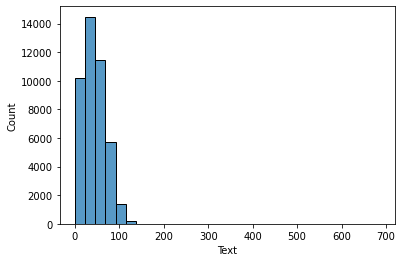

In [81]:
sns.histplot(train_set['Text'].apply(lambda text: len(text)), bins=30);

As we could expect, our sequencies are now shorter

We now split our dataset into data and labels

In [82]:
x_train = train_set['Text'].values
y_train = train_set['Emotion'].values

x_test = test_set['Text'].values
y_test = test_set['Emotion'].values

x_val = val_set['Text'].values
y_val = val_set['Emotion'].values

print('Dataset splits statistics: ')
print('Train data: ', x_train.shape)
print('Validation data: ', x_val.shape)
print('Test data: ', x_test.shape)

Dataset splits statistics: 
Train data:  (43410,)
Validation data:  (5426,)
Test data:  (5427,)


### **Tokenization**

Loading Embedding Model

In [83]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """

    download_path = ""

    # Find the correct embedding model name
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300

Checking OOV terms

In [84]:
# Function definition

def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """

    embedding_vocabulary = set(embedding_model.vocab.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

Building embedding matrix

In [85]:
# Function definition

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    :param oov_terms: list of OOV terms (list)

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

For tokenization i used the Keras Tokenizer, defining a simple high-level wrapper for the 'KerasTokenizer' class, which uses the functions i defined to build get the pre-trained embeddings, checking OOV terms and build the embedding matrix.

In [86]:
import tensorflow as tf

from collections import OrderedDict

class KerasTokenizer(object):
    """
    A simple high-level wrapper for the Keras tokenizer.
    """

    def __init__(self, build_embedding_matrix=False, embedding_dimension=None,
                 embedding_model_type=None, tokenizer_args=None):
        if build_embedding_matrix:
            assert embedding_model_type is not None
            assert embedding_dimension is not None and type(embedding_dimension) == int

        self.build_embedding_matrix = build_embedding_matrix
        self.embedding_dimension = embedding_dimension
        self.embedding_model_type = embedding_model_type
        self.embedding_model = None
        self.embedding_matrix = None
        self.vocab = None

        tokenizer_args = {} if tokenizer_args is None else tokenizer_args
        assert isinstance(tokenizer_args, dict) or isinstance(tokenizer_args, collections.OrderedDict)

        self.tokenizer_args = tokenizer_args

    def build_vocab(self, data, **kwargs):
        print('Fitting tokenizer...')
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(**self.tokenizer_args)
        self.tokenizer.fit_on_texts(data)
        print('Fit completed!')

        self.vocab = self.tokenizer.word_index

        if self.build_embedding_matrix:
            print('Loading embedding model! It may take a while...')
            self.embedding_model = load_embedding_model(model_type=self.embedding_model_type,
                                                        embedding_dimension=self.embedding_dimension)
            
            print('Checking OOV terms...')
            self.oov_terms = check_OOV_terms(embedding_model=self.embedding_model,
                                             word_listing=list(self.vocab.keys()))

            print('Building the embedding matrix...')
            self.embedding_matrix = build_embedding_matrix(embedding_model=self.embedding_model,
                                                           word_to_idx=self.vocab,
                                                           vocab_size=len(self.vocab) + 1,          
                                                           embedding_dimension=self.embedding_dimension,
                                                           oov_terms=self.oov_terms)
            print('Done!')


    def get_info(self):
        return {
            'build_embedding_matrix': self.build_embedding_matrix,
            'embedding_dimension': self.embedding_dimension,
            'embedding_model_type': self.embedding_model_type,
            'embedding_matrix': self.embedding_matrix.shape if self.embedding_matrix is not None else self.embedding_matrix,
            'embedding_model': self.embedding_model,
            'vocab_size': len(self.vocab) + 1,
        }

    def tokenize(self, text):
        return text

    def convert_tokens_to_ids(self, tokens):
        if type(tokens) == str:
            return self.tokenizer.texts_to_sequences([tokens])[0]
        else:
            return self.tokenizer.texts_to_sequences(tokens)

    def convert_ids_to_tokens(self, ids):
        return self.tokenizer.sequences_to_texts(ids)

Now let's build our vocabulary. Here i used only the training set for simplicity and to reduce the size of the embedding matrix.

In [87]:
tokenizer_args = {
    'oov_token': 1,      # The vocabulary id for unknown terms during text conversion
}
tokenizer = KerasTokenizer(tokenizer_args=tokenizer_args,
                           build_embedding_matrix=True,
                           embedding_dimension=300,
                           embedding_model_type="fasttext")

tokenizer.build_vocab(x_train)

tokenizer_info = tokenizer.get_info()

print('Tokenizer info: ', tokenizer_info)

Fitting tokenizer...
Fit completed!
Loading embedding model! It may take a while...
Checking OOV terms...
Building the embedding matrix...


100%|██████████| 27623/27623 [00:00<00:00, 221132.04it/s]

Done!
Tokenizer info:  {'build_embedding_matrix': True, 'embedding_dimension': 300, 'embedding_model_type': 'fasttext', 'embedding_matrix': (27624, 300), 'embedding_model': <gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f7e05ed4a10>, 'vocab_size': 27624}


Now we have to convert input data into numerical format, and apply some padding to make sure all our inputs are of the same size. In this case i applied a global padding in order to handle the majoriry of the data.

In [88]:
def convert_text(texts, tokenizer, is_training=False, max_seq_length=None):
    """
    Converts input text sequences using a given tokenizer

    :param texts: either a list or numpy ndarray of strings
    :tokenizer: an instantiated tokenizer
    :is_training: whether input texts are from the training split or not
    :max_seq_length: the max token sequence previously computed with
    training texts.

    :return
        text_ids: a nested list on token indices
        max_seq_length: the max token sequence previously computed with
        training texts.
    """

    text_ids = tokenizer.convert_tokens_to_ids(texts)

    # Padding
    if is_training:
        max_seq_length = int(np.quantile([len(seq) for seq in text_ids], 0.99))
    else:
        assert max_seq_length is not None

    text_ids = [seq + [0] * (max_seq_length - len(seq)) for seq in text_ids]
    text_ids = np.array([seq[:max_seq_length] for seq in text_ids])

    if is_training:
        return text_ids, max_seq_length
    else:
        return text_ids

# Train
x_train, max_seq_length = convert_text(x_train, tokenizer, True)
print("Max token sequence: {}".format(max_seq_length))

print('X train shape: ', x_train.shape)
print('Y train shape: ', y_train.shape)

# Val
x_val = convert_text(x_val, tokenizer, False, max_seq_length)

print('X val shape: ', x_val.shape)
print('Y val shape: ', y_val.shape)

# Test
x_test = convert_text(x_test, tokenizer, False, max_seq_length)

print('X test shape: ', x_test.shape)
print('Y test shape: ', y_test.shape)

Max token sequence: 16
X train shape:  (43410, 16)
Y train shape:  (43410,)
X val shape:  (5426, 16)
Y val shape:  (5426,)
X test shape:  (5427, 16)
Y test shape:  (5427,)


Now we have to One-Hot-Encode the labels

In [89]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse=False)

def onehot_encode(label_encoder, onehot_encoder, data):

  # define example
  values = array(data)

  # integer encode
  label_encoder.fit(values)
  integer_encoded = label_encoder.transform(data)

  # binary encode
  integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
  onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

  # reshape
  # onehot_encoded = onehot_encoded.reshape((onehot_encoded.shape[0]*onehot_encoded.shape[1],)) 

  return onehot_encoded

y_train = onehot_encode(label_encoder, onehot_encoder, y_train)
y_test = onehot_encode(label_encoder, onehot_encoder, y_test)
y_val = onehot_encode(label_encoder, onehot_encoder, y_val)

Define the functions to convert the labels back to strings

In [90]:
def decode_labels(labels):
  return label_encoder.inverse_transform(
      onehot_encoder.inverse_transform(labels))
  
def int_to_class(labels):
  return label_encoder.inverse_transform(labels)

## **Define The Model**

For the model architecture, i have decided to use a **Bidirectional LSTM** combined with a **CNN** (Convolutional Neural Network) layer. The idea behind this approach is that the LSTM layer will grab the information about the context of the sentence and the CNN will extract local features. After that i have added a couple of Dense layers for the final classification

In [91]:
from keras.layers import Input, Embedding, SpatialDropout1D, LSTM
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Bidirectional, Conv1D, Dense, concatenate
from keras.layers.core.dropout import Dropout
from keras.models import Model

In [92]:
input_dim = tokenizer_info['vocab_size']
num_classes = len(train_set['Emotion'].unique())
embedding_weights = tokenizer.embedding_matrix
embedding_dim = 300
input_length = max_seq_length
lstm_units = 128
lstm_dropout = 0.2
recurrent_dropout = 0.2
spatial_dropout = 0.3
filters = 64
kernel_size = 3

In [93]:
print(embedding_weights.shape)
print(input_dim)

(27624, 300)
27624


In [94]:
input_layer = Input(shape=(input_length,))

output_layer = Embedding(
  input_dim=input_dim,
  output_dim=embedding_dim,
  input_shape=(input_length,),
  embeddings_initializer=keras.initializers.Constant(embedding_weights),
  trainable=False
)(input_layer)

output_layer = SpatialDropout1D(spatial_dropout)(output_layer)

output_layer = Bidirectional(
LSTM(lstm_units, return_sequences=True,
     dropout=lstm_dropout, recurrent_dropout=recurrent_dropout)
)(output_layer)

output_layer = Conv1D(filters, kernel_size=kernel_size, padding='valid',
                    kernel_initializer='glorot_uniform')(output_layer)

avg_pool = GlobalAveragePooling1D()(output_layer)
max_pool = GlobalMaxPooling1D()(output_layer)
output_layer = concatenate([avg_pool, max_pool])

output_layer = Dense(256, activation='relu')(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dense(num_classes, activation='softmax')(output_layer)

model = Model(input_layer, output_layer)

Implementing a custom function for the F1-Score, since it is not available in the Keras metrics

In [95]:
from keras import backend as K

def f1_score(y_true, y_pred):

    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

Now is time to compile the model. I used the categorical crossentropy as a loss function and Adam as optimizer

In [96]:
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(learning_rate=1e-03), 
              metrics=[f1_score])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16)]         0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 16, 300)      8287200     ['input_4[0][0]']                
                                                                                                  
 spatial_dropout1d_3 (SpatialDr  (None, 16, 300)     0           ['embedding_3[0][0]']            
 opout1D)                                                                                         
                                                                                                  
 bidirectional_3 (Bidirectional  (None, 16, 256)     439296      ['spatial_dropout1d_3[0][0]

## **Train the model**

Let's define the batch size and the number of training epochs

In [97]:
batch_size = 128
epochs = 15

I also implement an Early Stopping callback to stop the training if the value of 'val_loss' doesn't improve for some consecutive epochs

In [98]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              restore_best_weights=True)

In [99]:
history = model.fit(x_train, 
                    y=y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/15
340/340 [==============================] - 50s 135ms/step - loss: 1.3046 - f1_score: 0.3847 - val_loss: 1.1421 - val_f1_score: 0.4796
Epoch 2/15
340/340 [==============================] - 45s 133ms/step - loss: 1.1489 - f1_score: 0.5038 - val_loss: 1.0682 - val_f1_score: 0.5247
Epoch 3/15
340/340 [==============================] - 45s 132ms/step - loss: 1.1049 - f1_score: 0.5246 - val_loss: 1.0336 - val_f1_score: 0.5682
Epoch 4/15
340/340 [==============================] - 46s 136ms/step - loss: 1.0777 - f1_score: 0.5402 - val_loss: 1.0223 - val_f1_score: 0.5929
Epoch 5/15
340/340 [==============================] - 45s 133ms/step - loss: 1.0605 - f1_score: 0.5501 - val_loss: 1.0121 - val_f1_score: 0.5967
Epoch 6/15
340/340 [==============================] - 45s 132ms/step - loss: 1.0423 - f1_score: 0.5616 - val_loss: 1.0004 - val_f1_score: 0.5900
Epoch 7/15
340/340 [==============================] - 45s 132ms/step - loss: 1.0277 - f1_score: 0.5688 - val_loss: 1.0049 - val_f1

Save the weights of the model

In [100]:
from pathlib import Path

model_file = Path('fasttext_model_weights.h5').resolve()
model.save_weights(model_file.as_posix())

## **Evaluate the model**

### **Training History**

Let's take a look at the training history, to see how the loss and the f1 score evolved

Displaying the following history keys:  dict_keys(['loss', 'f1_score', 'val_loss', 'val_f1_score'])


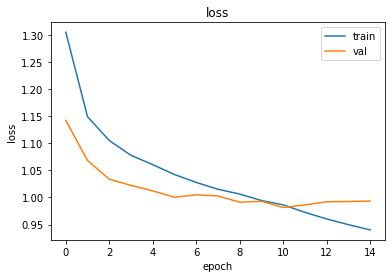

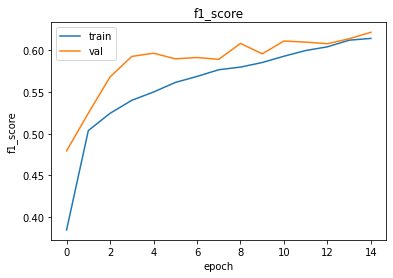

In [101]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from functools import partial

def show_history(history: keras.callbacks.History):
    """
    Shows training history data stored by the History Keras callback

    :param history: History Keras callback
    """

    history_data = history.history
    print("Displaying the following history keys: ", history_data.keys())

    for key, value in history_data.items():
        if not key.startswith('val'):
            fig, ax = plt.subplots(1, 1)
            ax.set_title(key)
            ax.plot(value)
            if 'val_{}'.format(key) in history_data:
                ax.plot(history_data['val_{}'.format(key)])
            else:
                print("Couldn't find validation values for metric: ", key)

            ax.set_ylabel(key)
            ax.set_xlabel('epoch')
            ax.legend(['train', 'val'], loc='best')

    plt.show()

show_history(history)

We can see that the loss on validation set is less than loss on training set more or less up to the 10th epoch. After that, the value of val_loss remains pretty much the same (with some oscillations), while the loss on the training set keeps decreasing (slower and slower), which means overfitting on training data. Then using an higher number of epochs won't be good for generalization

### **Testing the model**

Now we test the model by making some predictions on the test set. Then we print the results using `sklearn.classification_report`, which gives us the values of F1-score for each class and computes the macro-F1, i.e. the arithmetic mean (so not weighted) of F1 scores on all classes, which the metric we're looking for

In [102]:
# Inference

y_pred = model.predict(x_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
target_names = int_to_class(np.arange(7))
print(classification_report(y_pred, y_test, target_names=target_names))

43/43 [==============================] - 1s 13ms/step
              precision    recall  f1-score   support

       anger       0.38      0.49      0.42       442
     disgust       0.47      0.53      0.50       103
        fear       0.58      0.58      0.58        81
         joy       0.77      0.78      0.77      1966
     neutral       0.77      0.53      0.63      2417
     sadness       0.45      0.66      0.53       240
    surprise       0.19      0.71      0.29       178

    accuracy                           0.63      5427
   macro avg       0.52      0.61      0.53      5427
weighted avg       0.70      0.63      0.65      5427



As we can see, we do not achieve very good results, with a Macro-F1 of `0.53`. By looking the classification report, we can see that that's because the F1 value for some classes is really low, expecially for the `"surprise"` class which has an F1-score of `0.29`. One reason for this could be the small number of examples of `"surprise"` in our training data, which are "only" `5367`, with respect to `"joy"` which has `16217` examples instead (and it has a F1-score of `0.77` which is the highest among all classes). Indeed, we have seen at the beginning that our training set was not very balanced.

By the way, it's worth to notice that `"fear"` and `"disgust"` have an F1-score (`0.58` and `0.50`, respectively) which is way higher than the one for `"surprise"` even if we have very few examples of them in our training set (`768` for `"disgust"` and `561` for `"fear"`). So, even if a more balanced dataset could be useful, there are maybe other reasons behind that.